Name: Ashley Chen

GitHub user: ash54x

USC ID: 8562317194

1. Multi-class and Multi-Label Classification Using Support Vector Machines

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, hamming_loss, classification_report, silhouette_score
from sklearn.svm import SVC, LinearSVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from scipy.stats import mode

import warnings
warnings.filterwarnings("ignore")

(a) Load Data

In [16]:
data = pd.read_csv('Frogs_MFCCs.csv')

label_cols = ['Family', 'Genus', 'Species']

#features
X = data.drop(columns=label_cols)

#labels: three target columns
y = data[label_cols]

#encode each label column into integers
y_encoded = y.copy()
for col in label_cols:
    le = LabelEncoder()
    y_encoded[col] = le.fit_transform(y[col])

#train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42
)

display(data)

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7190,1.0,-0.554504,-0.337717,0.035533,0.034511,0.443451,0.093889,-0.100753,0.037087,0.081075,...,0.069430,0.071001,0.021591,0.052449,-0.021860,-0.079860,Hylidae,Scinax,ScinaxRuber,60
7191,1.0,-0.517273,-0.370574,0.030673,0.068097,0.402890,0.096628,-0.116460,0.063727,0.089034,...,0.061127,0.068978,0.017745,0.046461,-0.015418,-0.101892,Hylidae,Scinax,ScinaxRuber,60
7192,1.0,-0.582557,-0.343237,0.029468,0.064179,0.385596,0.114905,-0.103317,0.070370,0.081317,...,0.082474,0.077771,-0.009688,0.027834,-0.000531,-0.080425,Hylidae,Scinax,ScinaxRuber,60
7193,1.0,-0.519497,-0.307553,-0.004922,0.072865,0.377131,0.086866,-0.115799,0.056979,0.089316,...,0.051796,0.069073,0.017963,0.041803,-0.027911,-0.096895,Hylidae,Scinax,ScinaxRuber,60


(b)

i. Define Exact Match and Hamming Score

Exact Match, also known as a strict accuracy metric, indicates whether the model's predicted label set for an instance is perfectly identical to the true label set. It's a binary metric that's simple to understand and calculate, but is very strict, meaning a single incorrect label prediction results in 0 and may not be the best choice when partial matches are acceptable. 

Hamming Loss/Score measures the proportion of incorrectly predicted labels across all instances, calculated as the average number of inccorect labels predicted across all instances, while Hamming Score is 1 - Hamming Loss. It provies a more nuanced view of performance, as it considers partial matches and weighs the importance of different labels, but it can be sensitive to the number of labels in a dataset, as the average can be skewed by datasets with more labels. 

In [17]:
def exact_match(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def hamming_score(y_true, y_pred):
    return 1 - hamming_loss(y_true, y_pred)

ii. Binary Relevance SVM with RBF Kernel

In [21]:
#define parameter grid
C_range = [10.0, 100.0, 1000.0, 10000.0]
gamma_range = [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
param_grid = {'svc__C': C_range, 'svc__gamma': gamma_range}

for target_label in ['Family', 'Genus', 'Species']:
    print(f'\nTraining SVM for {target_label}')

    y_label_train = y_train[target_label]
    y_label_test = y_test[target_label]

    #create pipeline: scaler + SVC
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(kernel='rbf'))
    ])

    #grid search
    grid = GridSearchCV(pipeline, param_grid, cv=10, verbose=1, n_jobs=-1)
    grid.fit(X_train, y_label_train)

    #predict and evaluate
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    print(f'\nBest Parameter Values: {grid.best_params_}')
    print('\nPrediction Metrics:')
    print(classification_report(y_label_test, y_pred, digits=2))

    print('\nScores for different parameter options')
    for mean_score, params in zip(grid.cv_results_['mean_test_score'], grid.cv_results_['params']):
        print(f'Score = {mean_score:.2f} for {params}')


Training SVM for Family
Fitting 10 folds for each of 40 candidates, totalling 400 fits

Best Parameter Values: {'svc__C': 10.0, 'svc__gamma': 0.01}

Prediction Metrics:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        27
           1       1.00      1.00      1.00       162
           2       0.99      1.00      0.99       623
           3       1.00      1.00      1.00      1347

    accuracy                           1.00      2159
   macro avg       1.00      0.99      0.99      2159
weighted avg       1.00      1.00      1.00      2159


Scores for different parameter options
Score = 0.97 for {'svc__C': 10.0, 'svc__gamma': 0.001}
Score = 0.99 for {'svc__C': 10.0, 'svc__gamma': 0.01}
Score = 0.99 for {'svc__C': 10.0, 'svc__gamma': 0.1}
Score = 0.91 for {'svc__C': 10.0, 'svc__gamma': 1.0}
Score = 0.66 for {'svc__C': 10.0, 'svc__gamma': 10.0}
Score = 0.61 for {'svc__C': 10.0, 'svc__gamma': 100.0}
Score = 0.61 for {'svc__C': 10.

iii. L-1 Penalized SVMs (Standardized)

In [31]:
param_grid_l1 = {
    'svc__C': [0.01, 0.1, 1, 10, 100]
}

for label in ['Family', 'Genus', 'Species']:
    y_label_train = y_train[label]
    y_label_test = y_test[label]

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', LinearSVC(penalty='l1', dual=False, max_iter=1000000))
    ])

    grid = GridSearchCV(pipeline, param_grid_l1, cv=10, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_label_train)

    y_pred = grid.predict(X_test)

    print(f'\n{label}')
    print('Best Parameters:', grid.best_params_)
    print('Classification Report:')
    print(classification_report(y_label_test, y_pred))


Family
Best Parameters: {'svc__C': 100}
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.52      0.64        27
           1       0.91      0.95      0.93       162
           2       0.96      0.95      0.95       623
           3       0.97      0.98      0.98      1347

    accuracy                           0.96      2159
   macro avg       0.92      0.85      0.87      2159
weighted avg       0.96      0.96      0.96      2159


Genus
Best Parameters: {'svc__C': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1251
           1       0.95      0.95      0.95       162
           2       0.98      0.96      0.97        84
           3       0.97      1.00      0.98       468
           4       0.98      0.93      0.95        96
           5       0.91      0.85      0.88        34
           6       0.96      0.85      0.90        27
      

iv. L-1 Penalized SVMs + SMOTE

In [33]:
for label in ['Family', 'Genus', 'Species']:
    y_label_train = y_train[label]
    y_label_test = y_test[label]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_label_train)

    #train on resampled data
    model = LinearSVC(penalty='l1', dual=False, C=grid.best_params_['svc__C'], max_iter=1000000)
    model.fit(X_resampled, y_resampled)
    y_pred_smote = model.predict(X_test_scaled)

    print(f'\n{label}')
    print('Trained on SMOTE-resampled data using C =', grid.best_params_['svc__C'])
    print('Classification Report:')
    print(classification_report(y_label_test, y_pred_smote))


Family
Trained on SMOTE-resampled data using C = 1
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.93      0.83        27
           1       0.77      0.97      0.86       162
           2       0.94      0.93      0.94       623
           3       0.98      0.95      0.96      1347

    accuracy                           0.95      2159
   macro avg       0.86      0.94      0.90      2159
weighted avg       0.95      0.95      0.95      2159


Genus
Trained on SMOTE-resampled data using C = 1
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1251
           1       0.92      0.98      0.95       162
           2       0.92      0.96      0.94        84
           3       0.98      0.97      0.97       468
           4       0.96      0.94      0.95        96
           5       0.75      0.88      0.81        34
           6       0.80      0.89    

2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

(a) - (c)

In [55]:
def find_best_k(max_k, X, seed):
    best_k = 2
    best_score = -1

    for k in range(2, max_k + 1):
        model = KMeans(n_clusters=k, random_state=seed, n_init='auto')
        labels = model.fit_predict(X)
        score = silhouette_score(X, labels)

        if score > best_score:
            best_score = score
            best_k = k

    print(f'Best k: {best_k}')
    return best_k

def assign_majority_labels(k, cluster_labels, y_true):
    majority_labels = pd.DataFrame(columns=y_true.columns)

    for cluster in range(k):
        idx = np.where(cluster_labels == cluster)[0]
        cluster_subset = y_true.iloc[idx]

        row = []
        for col in y_true.columns:
            majority = cluster_subset[col].value_counts().idxmax()
            row.append(majority)
        majority_labels.loc[cluster] = row

    return majority_labels

def evaluate_clusters(majority_labels, cluster_labels, y_true):
    misclassified = 0
    for cluster in range(len(majority_labels)):
        idx = np.where(cluster_labels == cluster)[0]
        for i in idx:
            true_vals = y_true.iloc[i].values
            pred_vals = majority_labels.loc[cluster].values
            misclassified += np.sum(true_vals != pred_vals)

    hamming_dist = misclassified / len(y_true)
    hamming_loss = misclassified / (len(y_true) * y_true.shape[1])
    return hamming_dist, hamming_loss

def run_monte_carlo(iterations, X, y, max_k=50):
    dist_list = []
    loss_list = []

    for i in range(iterations):
        print(f'\nIteration {i + 1}')
        k = find_best_k(max_k, X, seed=i)
        model = KMeans(n_clusters=k, random_state=i, n_init='auto')
        cluster_labels = model.fit_predict(X)

        majority_labels = assign_majority_labels(k, cluster_labels, y)
        dist, loss = evaluate_clusters(majority_labels, cluster_labels, y)

        print(f'Hamming Distance: {round(dist, 4)}')
        print(f'Hamming Loss: {round(loss, 4)}')

        dist_list.append(dist)
        loss_list.append(loss)

    return dist_list, loss_list

distances, losses = run_monte_carlo(50, X_scaled, y)


Iteration 1
Best k: 2
Hamming Distance: 0.8909
Hamming Loss: 0.297

Iteration 2
Best k: 3
Hamming Distance: 0.7379
Hamming Loss: 0.246

Iteration 3
Best k: 2
Hamming Distance: 0.8909
Hamming Loss: 0.297

Iteration 4
Best k: 6
Hamming Distance: 0.5723
Hamming Loss: 0.1908

Iteration 5
Best k: 3
Hamming Distance: 0.7876
Hamming Loss: 0.2625

Iteration 6
Best k: 6
Hamming Distance: 0.4709
Hamming Loss: 0.157

Iteration 7
Best k: 2
Hamming Distance: 0.8909
Hamming Loss: 0.297

Iteration 8
Best k: 3
Hamming Distance: 0.6452
Hamming Loss: 0.2151

Iteration 9
Best k: 3
Hamming Distance: 0.7876
Hamming Loss: 0.2625

Iteration 10
Best k: 4
Hamming Distance: 0.6361
Hamming Loss: 0.212

Iteration 11
Best k: 5
Hamming Distance: 0.576
Hamming Loss: 0.192

Iteration 12
Best k: 3
Hamming Distance: 0.8409
Hamming Loss: 0.2803

Iteration 13
Best k: 5
Hamming Distance: 0.4784
Hamming Loss: 0.1595

Iteration 14
Best k: 2
Hamming Distance: 0.8909
Hamming Loss: 0.297

Iteration 15
Best k: 6
Hamming Distan

3. ISLR 12.6.2

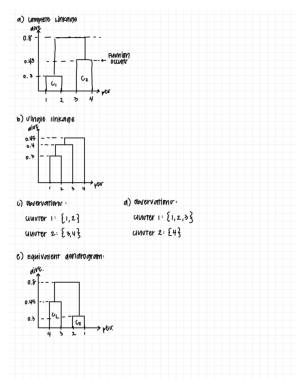

In [59]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img = mpimg.imread('hw7_question3.jpg')

plt.imshow(img)
plt.axis('off')
plt.show()